<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

DIANNA is a Python package that brings explainable AI (XAI) to your research project. It wraps carefully selected XAI methods in a simple, uniform interface. It's built by, with and for (academic) researchers and research software engineers working on machine learning projects.

### Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore') # disable warnings relateds to versions of tf
import numpy as np
import dianna
import onnx
import onnxruntime
from onnx_tf.backend import prepare
from scipy.special import softmax
import matplotlib.pyplot as plt
%matplotlib inline
from dianna import visualization
import random
random.seed(42)

### Model Interpretation for Pretrained Binary MNIST Model 

Loads pretrained binary MNIST model and the image to be explained.

Load saved binary MNIST data.

In [2]:
# load dataset
data = np.load('./data/binary-mnist.npz')
# load testing data and the related labels
X_test = data['X_test'].astype(np.float32).reshape([-1, 28, 28, 1]) / 256
y_test = data['y_test']

Load the pretrained binary MNIST model.

In [3]:
# Load saved onnx model
onnx_model_path = "./models/mnist_model_tf.onnx"
onnx_model = onnx.load(onnx_model_path)
# get the output node
output_node = prepare(onnx_model, gen_tensor_dict=True).outputs[0]

Print class and image of a single instance in the test data for preview.

The predicted class for this test image is: digit 0


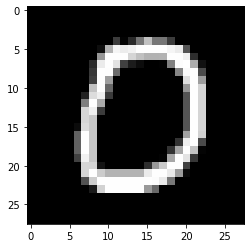

In [4]:
# class name
class_name = ['digit 0', 'digit 1']
# instance index
i_instance = 3
# select instance for testing
test_sample = X_test[i_instance]
# model predictions with added batch axis to test sample
predictions = prepare(onnx_model).run(test_sample[None, ...])[f'{output_node}']
pred_class = class_name[np.argmax(predictions)]
# get the index of predictions
top_preds = np.argsort(-predictions)
inds = top_preds[0]
print("The predicted class for this test image is:", pred_class)
plt.imshow(X_test[i_instance][:,:,0], cmap='gray')  # 0 for channel

#### 1. KernelSHAP

SHapley Additive exPlanations, in short, SHAP, is a model-agnostic explainable AI approach which is used to decrypt the black-box models through estimating the Shapley values.<br>

KernelSHAP is a variant of SHAP. It is a method that uses the LIME framework to compute Shapley Values, and visualizes the relevance attributions for each pixel/super-pixel by displaying them on the image. <br>

The user need to specified the number of times to re-evaluate the model when explaining each prediction (`nsamples`). A binary mask need to be applied to the image to represent if an image region is hidden. It requires the background color for the masked image, which can be specified by `background`.<br>

Performing KernelSHAP on each pixel is inefficient. It is always a good practice to segment the input image and perform computations on the obtained superpixels. This requires the user to specify some keyword arguments related to the segmentation, like the (approximate) number of labels in the segmented output image (`n_segments`), and width of Gaussian smoothing kernel for pre-processing for each dimension of the image (`sigma`).

In [5]:
# use KernelSHAP to explain the network's predictions
shap_values, segments_slic = dianna.explain_image(onnx_model_path, test_sample,
                                                  method="KernelSHAP", nsamples=1000,
                                                  background=0, n_segments=200, sigma=0,
                                                  axis_labels=('height','width','channels'))

  0%|          | 0/1 [00:00<?, ?it/s]

Define a function to fill each pixel with shap values based on the segmentation. <br>
This function is used to make plots.

In [6]:
# fill each pixel with SHAP values 
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

Visualize Shapley scores on the images.

Explaination for `digit 0` with KernelSHAP


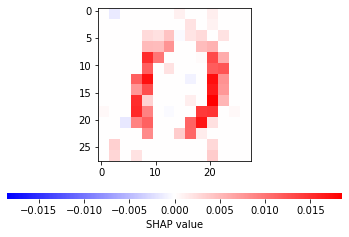

In [7]:
# Visualize the explanations
# get the range for color bar
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
# plot the test image and the attributions on the image for class 0

m = fill_segmentation(shap_values[inds[0]][0], segments_slic)
print(f'Explaination for `{pred_class}` with KernelSHAP')

im = plt.imshow(m, vmin=-max_val, vmax=max_val, cmap='bwr')
cb = plt.colorbar(im, label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)


The Shapley scores are estimated using KernelSHAP for models used to categorize the binary MNIST. The example here shows that the KernelSHAP method evaluates the importance of each segmentation/super pixel to the classification and the results are reasonable compared to the human visual preception of the chosen testing hand-written digit image.

#### 2. RISE

RISE is short for Randomized Input Sampling for Explanation of Black-box Models. It estimates the relevance empirically by probing the model with randomly masked versions of the input image to obtain the corresponding outputs.<br>


RISE masks random portions of the input image and passes the masked image through the model — the portion that decreases the accuracy the most is the most “important” portion.<br>
To call the explainer and generate the relevance scores, the user need to specified the number of masks being randomly generated (`n_masks`), the resolution of features in masks (`feature_res`) and for each mask and each feature in the image, the probability of being kept unmasked (`p_keep`).

In [8]:
relevances = dianna.explain_image(onnx_model_path, test_sample, method="RISE",
                                labels=[i for i in range(2)],
                                n_masks=5000, feature_res=8, p_keep=.1,
                                axis_labels=('height','width','channels'))[0]

Explaining: 100%|██████████| 50/50 [00:01<00:00, 38.62it/s]


Visualize the relevance scores for the predicted class on top of the image.

Explaination for `digit 0` with RISE


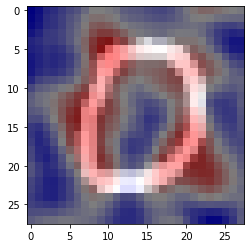

In [9]:
print(f'Explaination for `{pred_class}` with RISE')
visualization.plot_image(relevances, X_test[i_instance][:,:,0], data_cmap='gray', heatmap_cmap='bwr')

#### 3. LIME

LIME (Local Interpretable Model-agnostic Explanations) is an explainable-AI method that aims to create an interpretable model that locally represents the classifier.


In [10]:
# need to preprocess, because we divided the input data by 256 for the models and LIME needs RGB values
def preprocess_function(image):
    return (image / 256).astype(np.float32)

# An explanation is returned for each label, but we ask for just one label so the output is a list of length one.
explanation_heatmap = dianna.explain_image(onnx_model_path, test_sample * 256, 'LIME',
                                           axis_labels=('height','width','channels'),
                                           random_state=2,
                                           labels=[i for i in range(2)], preprocess_function=preprocess_function)

  0%|          | 0/5000 [00:00<?, ?it/s]

Explaination for `digit 0` with LIME


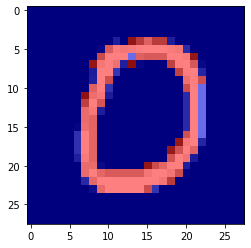

In [11]:
print(f'Explaination for `{pred_class}` with LIME')
visualization.plot_image(explanation_heatmap[0], X_test[i_instance][:,:,0], heatmap_cmap='bwr')